In [1]:
# !unzip text_adventure_games.zip

In [2]:
# !apt install graphviz

In [3]:
from text_adventure_games import games, parsing, actions, things, blocks, viz

In [4]:
# Locations
launch_site = things.Location(
    "Launch Site",
    "You are at the Mars launch site. Your rocket stands nearby, ready for departure."
)
crater = things.Location(
    "Crater",
    "You are in a large crater. The rocky Martian landscape stretches out around you."
)
abandoned_station = things.Location(
    "Abandoned Research Station",
    "A derelict facility with potential resources. Dust covers old equipment."
)
olympus_mons = things.Location(
    "Olympus Mons Base Camp",
    "A small outpost at the base of the massive volcano. The peak looms above."
)
valles_marineris = things.Location(
    "Valles Marineris Canyon",
    "A deep, winding canyon system. The walls tower above you on both sides."
)
ancient_ruins = things.Location(
    "Ancient Martian Ruins",
    "Mysterious structures hinting at past civilization. Strange symbols cover the walls."
)
ice_caverns = things.Location(
    "Underground Ice Caverns",
    "A network of icy caves beneath the surface. The air is frigid and still."
)
phobos_facility = things.Location(
    "Phobos Mining Facility",
    "A small base on Mars' largest moon. Earth is visible as a tiny blue dot in the sky."
)

# Map connections
launch_site.add_connection("east", crater)
crater.add_connection("west", launch_site)
crater.add_connection("north", olympus_mons)
crater.add_connection("east", abandoned_station)
olympus_mons.add_connection("south", crater)
olympus_mons.add_connection("east", valles_marineris)
abandoned_station.add_connection("west", crater)
abandoned_station.add_connection("south", ancient_ruins)
valles_marineris.add_connection("west", olympus_mons)
valles_marineris.add_connection("down", ice_caverns)
ancient_ruins.add_connection("north", abandoned_station)
ice_caverns.add_connection("up", valles_marineris)
phobos_facility.add_connection("return", launch_site)

# Ensure bi-directional connections
crater.add_connection("east", abandoned_station)
abandoned_station.add_connection("west", crater)
ancient_ruins.add_connection("north", abandoned_station)
abandoned_station.add_connection("south", ancient_ruins)
valles_marineris.add_connection("down", ice_caverns)
ice_caverns.add_connection("up", valles_marineris)

crater.add_connection("south", valles_marineris)
valles_marineris.add_connection("north", crater)


In [5]:
# Items
map_item = things.Item("map", "a Martian map", "A MAP SHOWING KEY LOCATIONS ON MARS.")
access_key = things.Item("key", "an Access Key", "UNLOCKS SECURE AREAS IN VARIOUS LOCATIONS.")
healer_element = things.Item("healer", "the Healer Element", "A GLOWING SUBSTANCE THAT CAN SAVE EARTH.")
oxygen_recycler = things.Item("recycler", "an Oxygen Recycler", "EXTENDS YOUR EXPLORATION TIME IF REPAIRED.")
radiation_shield = things.Item("shield", "a Radiation Shield", "PROTECTS FROM HARMFUL MARTIAN RADIATION.")
soil_sample = things.Item("sample", "a Martian Soil Sample", "CONTAINS CRUCIAL SCIENTIFIC DATA.")
artifact = things.Item("artifact", "an Ancient Martian Artifact", "HOLDS CLUES TO THE PLANET'S HISTORY.")
shuttle_pass = things.Item("pass", "a Phobos Shuttle Pass", "ALLOWS TRAVEL TO AND FROM PHOBOS.")

# Place items in locations
launch_site.add_item(map_item)
crater.add_item(oxygen_recycler)
olympus_mons.add_item(access_key)
valles_marineris.add_item(soil_sample)
ancient_ruins.add_item(artifact)
ancient_ruins.add_item(shuttle_pass)
ice_caverns.add_item(healer_element)
phobos_facility.add_item(radiation_shield)
valles_marineris.add_item(soil_sample)
valles_marineris.add_item(radiation_shield)
ice_caverns.add_item(healer_element)

In [6]:
# Player
player = things.Character(
    name="Astronaut",
    description="A brave astronaut on a mission to save Earth.",
    persona="I must find the Healer element and return to Earth!",
)

In [7]:
class LaunchRocket(actions.Action):
    ACTION_NAME = "launch rocket"
    ACTION_DESCRIPTION = "Launch the rocket to return to Earth"
    ACTION_ALIASES = ["blast off", "return to earth"]

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command

    def check_preconditions(self) -> bool:
        if self.game.player.location.name != "Launch Site":
            self.game.parser.fail("You need to be at the Launch Site to launch the rocket.")
            return False

        missing_items = []
        if "healer" not in self.game.player.inventory:
            missing_items.append("Healer element")
        if "sample" not in self.game.player.inventory:
            missing_items.append("Martian Soil Sample")
        if "artifact" not in self.game.player.inventory:
            missing_items.append("Ancient Martian Artifact")

        if missing_items:
            self.game.parser.fail(f"You're missing the following items: {', '.join(missing_items)}.")
            return False

        return True

    def apply_effects(self):
        self.game.parser.ok("You launch the rocket with all necessary items on board. Earth is saved! You win!")
        self.game.player.set_property("has_won", True)

In [8]:
class RepairRecycler(actions.Action):
    ACTION_NAME = "repair recycler"
    ACTION_DESCRIPTION = "Attempt to repair the Oxygen Recycler"

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command

    def check_preconditions(self) -> bool:
        if "recycler" not in self.game.player.inventory:
            self.game.parser.fail("You don't have the Oxygen Recycler.")
            return False
        if self.game.player.location.name != "Abandoned Research Station":
            self.game.parser.fail("You need to be at the Abandoned Research Station to repair the recycler.")
            return False
        return True

    def apply_effects(self):
        self.game.parser.ok("You successfully repair the Oxygen Recycler, extending your exploration time!")
        self.game.player.set_property("extended_oxygen", True)

In [9]:
# Update the ActivateHealer action
class ActivateHealer(actions.Action):
    ACTION_NAME = "activate healer"
    ACTION_DESCRIPTION = "Activate the Healer Element using the Ancient Martian Artifact"

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command

    def check_preconditions(self) -> bool:
        if "healer" not in self.game.player.inventory:
            self.game.parser.fail("You don't have the Healer Element.")
            return False
        if "artifact" not in self.game.player.inventory:
            self.game.parser.fail("You need the Ancient Martian Artifact to activate the Healer Element.")
            return False
        return True

    def apply_effects(self):
        self.game.parser.ok("You use the Ancient Martian Artifact to activate the Healer Element. It glows with intense energy!")
        self.game.player.set_property("healer_activated", True)

In [10]:
# Update the VolcanicPressurePuzzle block
class VolcanicPressurePuzzle(blocks.Block):
    def __init__(self, location: things.Location, game: games.Game):
        super().__init__("The access to the base camp is blocked by a pressure lock", "You need to solve the volcanic pressure puzzle to enter.")
        self.location = location
        self.game = game

    def is_blocked(self) -> bool:
        return not self.game.player.get_property("solved_pressure_puzzle")

In [11]:
class RadiationBarrier(blocks.Block):
    def __init__(self, location: things.Location, game: games.Game):
        super().__init__("Intense radiation blocks your path", "You need protection from the radiation to proceed.")
        self.location = location
        self.game = game

    def is_blocked(self) -> bool:
        return "shield" not in self.game.player.inventory

In [12]:
# Add a solve puzzle action
class SolvePressurePuzzle(actions.Action):
    ACTION_NAME = "solve puzzle"
    ACTION_DESCRIPTION = "Solve the volcanic pressure puzzle"

    def __init__(self, game, command):
        super().__init__(game)
        self.command = command

    def check_preconditions(self) -> bool:
        return self.game.player.location.name == "Crater"

    def apply_effects(self):
        self.game.player.set_property("solved_pressure_puzzle", True)
        self.game.parser.ok("You solved the volcanic pressure puzzle!")

In [13]:
class EscapeMars(games.Game):
    def __init__(self, start_at: things.Location, player: things.Character, custom_actions=None):
        super().__init__(start_at, player, custom_actions=custom_actions)

        # Add blocks
        olympus_mons_block = VolcanicPressurePuzzle(olympus_mons, self)
        crater.add_block("north", olympus_mons_block)

        radiation_block = RadiationBarrier(valles_marineris, self)
        olympus_mons.add_block("east", radiation_block)

    def is_won(self) -> bool:
        has_won = self.player.get_property("has_won")
        return has_won is True

    def game_loop(self):
        self.parser.parse_command("look")

        while True:
            command = input("\n> ")
            commands = [cmd.strip() for cmd in command.split(',')]
            for cmd in commands:
                try:
                    self.parser.parse_command(cmd)
                except Exception as e:
                    print(f"Error processing command '{cmd}': {str(e)}")
                if self.is_won() or self.is_game_over():
                    return

In [14]:
custom_actions = [LaunchRocket, RepairRecycler, ActivateHealer, SolvePressurePuzzle]
game = EscapeMars(launch_site, player, custom_actions=custom_actions)

# Start the game
game.game_loop()

# take map, go east, take recycler, go east, repair recycler, go south, take artifact, take pass, go north, go west, go north, take key, go south, go east, take shield, go east, take sample, go down, take healer, activate healer, go up, go west, go west, go west, go west, launch rocket

You are at the Mars launch site. Your rocket stands nearby, ready for departure.
Exits:
East to Crater

You see:
 * a Martian map



> take map, go east, take recycler, go east, repair recycler, go south, take artifact, go north, go west, solve puzzle, go north, take key, go south, go south, take sample, take shield, go down, take healer, go up, go north, go west, launch rocket
Astronaut got the map.
You are in a large crater. The rocky Martian landscape stretches out around you.
Exits:
West to Launch Site
North to Olympus Mons Base Camp
East to Abandoned Research Station
South to Valles Marineris Canyon

You see:
 * an Oxygen Recycler


Astronaut got the recycler.
A derelict facility with potential resources. Dust covers old equipment.
Exits:
West to Crater
South to Ancient Martian Ruins




You successfully repair the Oxygen Recycler, extending your exploration time!
Mysterious structures hinting at past civilization. Strange symbols cover the
walls.
Exits:
North to Abandoned Researc

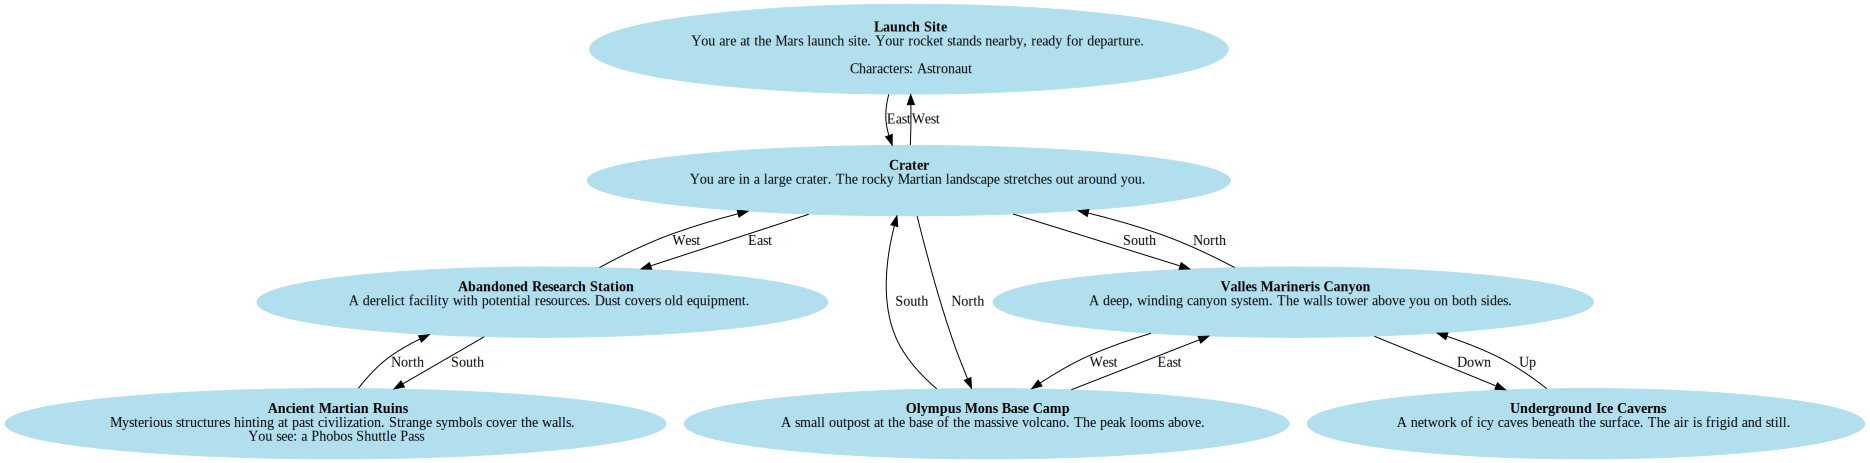

In [15]:
from text_adventure_games.viz import Visualizer
viz = Visualizer(game)
graph = viz.visualize()
graph

In [16]:
graph.render("escape_mars_map", format="svg", cleanup=True)

'escape_mars_map.svg'